<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/09_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章 深層学習


## 課題1

畳み込みネットワークにおいて使用するデータをfasion MNISTに変更し、認識・評価を行ってください。また、余力があればdropoutの効果を検証してください。

参考コード
https://keras.io/examples/mnist_cnn/

## 畳み込みネットワークによる画像認識

## 準備

必要なライブラリ等を読み込みます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import np_utils

Using TensorFlow backend.


## データの読み込み

fasion MNISTデータ（学習用60000事例、評価用10000事例、それぞれ28x28の行列）を使います。

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


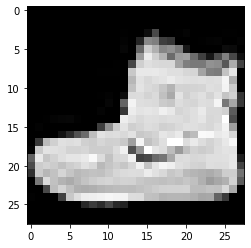

In [3]:
plt.gray()
plt.imshow(X_train[0])

入力を3次元テンソルから4次元テンソルに変換します。各次元は、データ数、縦のピクセル数、横のピクセル数、チャネル数（グレースケース画像は1）を表します。また、学習用データを10000個に制限します。

In [0]:

X_train = X_train.reshape(X_train.shape[0] , 28, 28, 1) [0:10000]
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) 
y_train = y_train[0:10000]

値の型をTensorflowで演算に用いられるfloat32に変換します。

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

値のとりうる範囲を0-255から0-1に変換します。

In [0]:
X_train /= 255
X_test /= 255

まず、通常の3階層ネットワークで学習・評価します。

In [7]:
model1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [8]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
10000/10000 [==============================] - 2s 186us/step - loss: 0.8697 - accuracy: 0.7110
Epoch 2/5
10000/10000 [==============================] - 0s 19us/step - loss: 0.5484 - accuracy: 0.8117
Epoch 3/5
10000/10000 [==============================] - 0s 20us/step - loss: 0.4863 - accuracy: 0.8316
Epoch 4/5
10000/10000 [==============================] - 0s 19us/step - loss: 0.4593 - accuracy: 0.8369
Epoch 5/5
10000/10000 [==============================] - 0s 20us/step - loss: 0.4275 - accuracy: 0.8504


In [9]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 41us/step
Test accuracy: 0.8299000263214111


畳み込みネットワークで学習します。

In [10]:
model2 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [11]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
10000/10000 [==============================] - 5s 474us/step - loss: 1.0878 - accuracy: 0.6288
Epoch 2/5
10000/10000 [==============================] - 0s 28us/step - loss: 0.5821 - accuracy: 0.7849
Epoch 3/5
10000/10000 [==============================] - 0s 28us/step - loss: 0.4901 - accuracy: 0.8178
Epoch 4/5
10000/10000 [==============================] - 0s 28us/step - loss: 0.4554 - accuracy: 0.8322
Epoch 5/5
10000/10000 [==============================] - 0s 29us/step - loss: 0.4335 - accuracy: 0.8439


In [12]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 50us/step
Test accuracy: 0.8266000151634216


Dropoutを入れます。半数が消えているので、epochは倍の回数をとります。

In [13]:
model3 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [14]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
10000/10000 [==============================] - 0s 44us/step - loss: 1.3738 - accuracy: 0.5226
Epoch 2/10
10000/10000 [==============================] - 0s 29us/step - loss: 0.7551 - accuracy: 0.7219
Epoch 3/10
10000/10000 [==============================] - 0s 31us/step - loss: 0.6598 - accuracy: 0.7548
Epoch 4/10
10000/10000 [==============================] - 0s 29us/step - loss: 0.6130 - accuracy: 0.7673
Epoch 5/10
10000/10000 [==============================] - 0s 29us/step - loss: 0.5827 - accuracy: 0.7831
Epoch 6/10
10000/10000 [==============================] - 0s 31us/step - loss: 0.5638 - accuracy: 0.7875
Epoch 7/10
10000/10000 [==============================] - 0s 30us/step - loss: 0.5338 - accuracy: 0.8029
Epoch 8/10
10000/10000 [==============================] - 0s 29us/step - loss: 0.5250 - accuracy: 0.8045
Epoch 9/10
10000/10000 [==============================] - 0s 29us/step - loss: 0.5020 - accuracy: 0.8140
Epoch 10/10
10000/10000 [==============================

評価用データで評価します。

In [15]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 50us/step
Test accuracy: 0.8416000008583069


## リカレントニューラルネットワークによる自然言語処理

## 課題2

リカレントニューラルネットワークにおいて、双方向LSTMにネットワーク構造を変更し、性能の変化を確認してください。

In [0]:
from keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional

In [18]:
max_features = 10000
maxlen = 50
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


単語インデックスを単語に戻して、元のデータを確認します。インデックスは"padding", "start of sequence","unknown"にそれぞれ0,1,2が割り当てられているので、3つずらして対応させます。

In [19]:
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

1646592/1641221 [==============================] - 0s 0us/step


"grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

単純なRNNを構成して学習させます。

In [20]:
model = Sequential([
    Embedding(max_features, 128),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
]) 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,292,417
Trainable params: 1,292,417
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=2, batch_size=32,validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 20s 1ms/step - loss: 0.5522 - acc: 0.7016 - val_loss: 0.4924 - val_acc: 0.7658
Epoch 2/2
20000/20000 [==============================] - 20s 1ms/step - loss: 0.3325 - acc: 0.8594 - val_loss: 0.4900 - val_acc: 0.7828


In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 3s 123us/step
Test accuracy: 0.7850000262260437


bi-LSTMに変更します。

In [0]:
model2 = Sequential([
    Embedding(max_features, 128),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
]) 

In [24]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.fit(X_train, y_train, epochs=2, batch_size=32,validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 104s 5ms/step - loss: 0.4652 - acc: 0.7737 - val_loss: 0.4042 - val_acc: 0.8086
Epoch 2/2
20000/20000 [==============================] - 103s 5ms/step - loss: 0.2926 - acc: 0.8763 - val_loss: 0.4456 - val_acc: 0.7984


In [25]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 11s 440us/step
Test accuracy: 0.8025599718093872
